## Module 2 - Lab using R


In this notebook the R package [**`arules`**](https://cran.r-project.org/web/packages/arules/vignettes/arules.pdf) is used that has functions for creating and manipulating data for ining association rules and also analyze the resulting itemsets and rules. It also includes interfaces for some of the popular mining algorithms **`Apriori`** and **`Eclat`** by Christian Borgelt. 

**_Apriori: _ ** is a level-wise, breadth-first algorithm which counts transactions. Go through the slides to understand how apriori works. 

**_Eclat: _** employs equivalence classes, depth-first search and set intersection instead of counting. These algorithms can mine frequent itemsets, maximal frequent itemsets, closed frequent itemsets and association rules. Different measures of interestingness are used to describe analyze and present association rules discovered in data. Some of these measures are discussed as following. 


** Association Rules:** Let I = {i1, i2, . . . , in} be a set of n binary attributes called items. Let D = {t1, t2, . . . , tm}
be a set of transactions called the database. Each transaction in D has a unique transaction ID and contains a subset of the items in I. A rule is defined as an implication of the form **X ⇒ Y** where **_X_, _Y_ ⊆ _I_** and **_X_ ∩ _Y_ = ∅**. The sets of items (for short itemsets) X and Y are called antecedent (LHS) and consequent (RHS) of the rule.


As explained in slides, consider the example from the supermarket domain. The set of items is I = {milk, bread, butter, beer} and a small database containing the items is shown below. 

<img src='../images/market_data.PNG'>

An example rule for the supermarket could be {milk, bread} ⇒ {butter} meaning that if milk and bread is bought, customers also buy butter. 

### Representing collections of itemsets


Both transaction databases and sets of associations have in common that they contain sets of items (itemsets) together with additional information. For example, a transaction in the database contains a transaction ID and an itemset. A rule in a set of mined association rules contains two itemsets, one for the LHS and one for the RHS, and additional quality information, e.g., values for various interest measures.

Collections of itemsets used for transaction databases and sets of associations can be represented as binary incidence matrices with columns corresponding to the items and rows corresponding to the itemsets. The matrix entries represent the presence (1) or absence (0) of an item in a particular itemset. Shown below on the left, an example of a binary incidence matrix containing itemsets for above supermarket data example and vertical layout for the same is shown on right. 

<img src="../images/data_representation.PNG">


Since a typical frequent itemset or a typical transaction (e.g., a supermarket transaction)
only contains a small number of items compared to the total number of available items, the
binary incidence matrix will in general be very sparse with many items and a very large
number of rows. A natural representation for such data is a sparse matrix format.

### Associations: itemsets and sets of rules


Mining transaction data using arules package results in finding associations. Conceptually, associations are sets of objects describing the relationship between some items which have assigned values for different measures of quality. Such measures can be measures of significance (e.g., support), or measures of interestingness (e.g., confidence, lift), or other measures (e.g., revenue covered by the association).


### Sampling from transactions

Taking samples from large databases for mining is a powerful technique which is especially useful if the original database does not fit into main memory, but the sample does. However, even if the database fits into main memory, sampling can provide an enormous speed-up for mining at the cost of only little degradation of accuracy

### Preparing and mining a questionnaire data set

Analyze and manipulate the dataset before any associations are mined. Its an important step as it helps find problems in the data set which could make the mined associations useless or at least inferior to associations mined on a properly prepared data set. 

The notebook uses the Adult dataset from the UCI machine learning repository provided by package **[arules](https://cran.r-project.org/web/packages/arules/vignettes/arules.pdf)**. This data set originates from the U.S. census bureau database and contains 48842 instances with 14 attributes like age, work class, education, etc. In the original applications of the data, the attributes were used to predict the income level of individuals.

In [1]:
# install.packages("arules",repo="http://cran.mtu.edu/")
library("arules")

Loading required package: Matrix

Attaching package: ‘arules’

The following objects are masked from ‘package:base’:

    abbreviate, write



In [2]:
data("AdultUCI")

In [3]:
dim(AdultUCI)

[1] 48842    15

Take a look at first two rows in the data

In [6]:
AdultUCI[1:2,]

age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,small
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,small


The data is a combination of categorical and numeric attributes. It needs some data cleaning before it can be converted into transaction data for any association rule mining. First, remove the attributes **fnlwgt** and **education-num**. **fnlwgt** is a weight calculated by the creator of the data set. **education-num** is just a numeric representation of the attribute education which is also part of the data set.

Assigning a column to NULL will delete the column from dataframe.

In [7]:
AdultUCI[["fnlwgt"]] <- NULL
AdultUCI[["education-num"]] <- NULL

Next, map the four numeric attributes (age, hours-per-week, capital-gain and capital-loss) to ordinal attributes by building suitable categories. Divide the attributes age and hours-per-week into suitable categories using knowledge about typical age groups and working hours. For the two capital related attributes, create a category called None for cases which have no gains/losses. Further divide the group with gains/losses at their median into two categories Low and High.

**_Ordered factors are different from factors:_ ** Ordered values are similar to factor type data and is like an extension of factors. To create an ordered factor in R, you have two options:
- Use the factor() function with the argument ordered=TRUE.
- Use the ordered() function.

Use the factor() function for nominal data and the ordered() function for ordinal data. R then will treat the data appriopriately. Factor and ordered are used the same way, with the same arguments. The former creates factors and the later creates ordered factors. [Click this link](http://www.dummies.com/programming/r/how-to-work-with-ordered-factors-in-r/) for more info.

----
**_cut():_** From R library, cut divides the range of x into intervals and codes the values in x according to which interval they fall. The leftmost interval corresponds to level one, the next leftmost to level two and so on.

So in below lines of code, we are splitting the column data into intervals as specified in the vector c() and code them into values according to list of labels. The order of labels is important labels = c("Young", "Middle-aged", "Senior", "Old") is different from labels = c("old","Senior", "Middle-aged","Young"). You have to tell R the right order of labels.

In [8]:
AdultUCI[[ "age"]] <- ordered(cut(AdultUCI[[ "age"]], c(15,25,45,65,100)), labels = c("Young", "Middle-aged", "Senior", "Old"))

In [9]:
AdultUCI[[ "hours-per-week"]] <- ordered(cut(AdultUCI[[ "hours-per-week"]], c(0,25,40,60,168)), labels = c("Part-time", "Full-time", "Over-time", "Workaholic"))

In [10]:
AdultUCI[[ "capital-gain"]] <- ordered(cut(AdultUCI[[ "capital-gain"]], c(-Inf,0,median(AdultUCI[[ "capital-gain"]][AdultUCI[[ "capital-gain"]]>0]),Inf)),labels = c("None", "Low", "High"))

In [11]:
AdultUCI[[ "capital-loss"]] <- ordered(cut(AdultUCI[[ "capital-loss"]],c(-Inf,0, median(AdultUCI[[ "capital-loss"]][AdultUCI[[ "capital-loss"]]>0]),Inf)),labels = c("none", "low", "high"))

In [12]:
head(AdultUCI)

age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
Middle-aged,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,Low,none,Full-time,United-States,small
Senior,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,None,none,Part-time,United-States,small
Middle-aged,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,None,none,Full-time,United-States,small
Senior,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,None,none,Full-time,United-States,small
Middle-aged,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,None,none,Full-time,Cuba,small
Middle-aged,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,None,none,Full-time,United-States,small


Now, the data can be automatically recoded as a binary incidence matrix by coercing the data set to transactions.

In [13]:
Adult <- as(AdultUCI, "transactions")
Adult

transactions in sparse format with
 48842 transactions (rows) and
 115 items (columns)

There are 115 unique levels of data which form as columns and ofcourse 48842 transactions for the 48842 rows of original data.

In [14]:
inspect(Adult[1:2])

    items                               transactionID
[1] {age=Middle-aged,                                
     workclass=State-gov,                            
     education=Bachelors,                            
     marital-status=Never-married,                   
     occupation=Adm-clerical,                        
     relationship=Not-in-family,                     
     race=White,                                     
     sex=Male,                                       
     capital-gain=Low,                               
     capital-loss=none,                              
     hours-per-week=Full-time,                       
     native-country=United-States,                   
     income=small}                                  1
[2] {age=Senior,                                     
     workclass=Self-emp-not-inc,                     
     education=Bachelors,                            
     marital-status=Married-civ-spouse,              
     occupation=Exec-manager

The 115 categorical attributes were automatically recoded into 115 binary items. During encoding, the item labels were generated in the form of `<variable name>=<category label>`. Note that for cases with missing values all items corresponding to the attributes with the missing values were set to zero.

In [15]:
summary(Adult)

transactions as itemMatrix in sparse format with
 48842 rows (elements/itemsets/transactions) and
 115 columns (items) and a density of 0.1089939 

most frequent items:
           capital-loss=none            capital-gain=None 
                       46560                        44807 
native-country=United-States                   race=White 
                       43832                        41762 
           workclass=Private                      (Other) 
                       33906                       401333 

element (itemset/transaction) length distribution:
sizes
    9    10    11    12    13 
   19   971  2067 15623 30162 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.00   12.00   13.00   12.53   13.00   13.00 

includes extended item information - examples:
           labels variables      levels
1       age=Young       age       Young
2 age=Middle-aged       age Middle-aged
3      age=Senior       age      Senior

includes extended transaction information - examp

The summary of the transaction data set gives a rough overview showing the most frequent items, the length distribution of the transactions and the extended item information which shows which variable and which value were used to create each binary item. 

In the first example we see that the item with label age=Middle-aged was generated by variable age and level middle-aged. age=Middle-aged is one of the 115 columns in the matrix. To see which items are important in the data set we can use the itemFrequencyPlot(). To reduce the number of items, we only plot the item frequency for items with a support greater than 30% (using the parameter support). For better readability of the labels, we reduce the label size with the parameter cex.names.

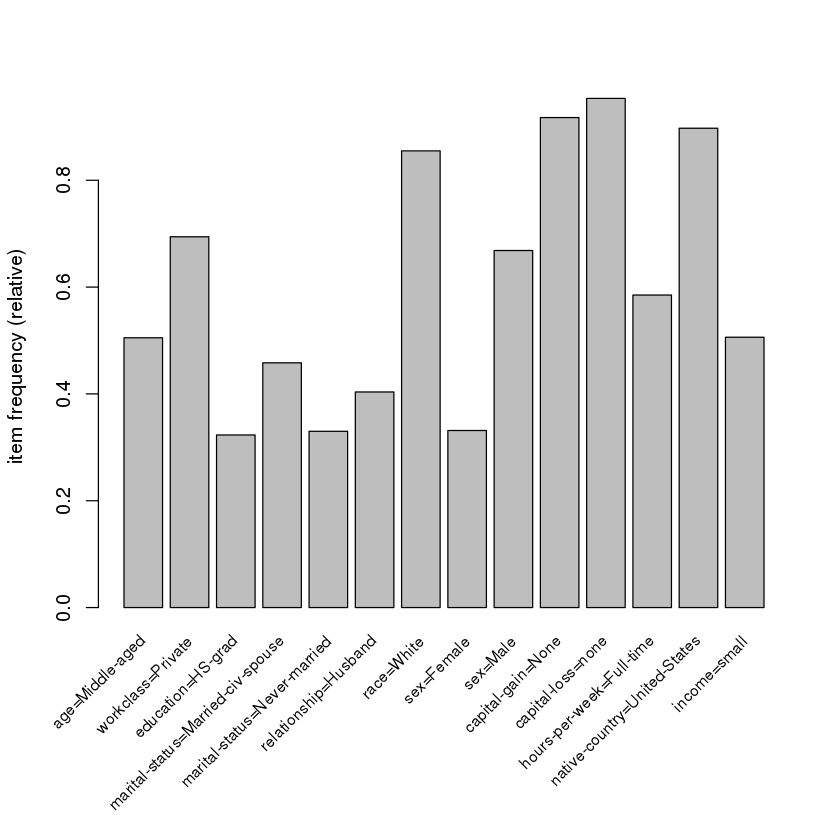

In [16]:
itemFrequencyPlot(Adult, support = 0.3, cex.names=0.8)

### Interest Measures

Many organizations generate a large amount of transaction data on a daily basis. For example, a department store like Macy’s stores customer shopping information at a large scale using check-out data. Association rule mining is one of the major techniques to detect and extract useful information from large scale transaction data.

#### Support and Confidence

Association rules are rules which surpass a user-specified minimum support and minimum confidence threshold. The support supp(X) of an itemset X is defined as the proportion of transactions in the data set which contain the itemset and the confidence of a rule is defined **_conf(X ⇒ Y )_** = **_supp(X ∪ Y )/supp(X)_**. Therefore, an association rule X ⇒ Y will satisfy below where where $\sigma$ and δ are the minimum support and minimum confidence, respectively.

$$ supp(X ∪ Y ) ≥ \sigma $$

                                                and

$$ conf(X ⇒ Y ) ≥ δ $$



#### lift 

Another popular measure for association rules is lift. The lift of a rule is defined as

$$ lift(X ⇒ Y ) = \frac{supp(X ∪ Y )}{(supp(X)supp(Y ))} $$

Above formula can be interpreted as the deviation of the support of the whole rule from the support expected under independence given the supports of both sides of the rule. Greater lift values indicate stronger associations. Measures like support, confidence and lift are generally called interest measures because they help with focusing on potentially more interesting rules.

Check the [reading material](../Resources/Basic_association_analysis.pdf) for detailed explanation

Next, call the function apriori() to find all ruleswith a minimum support of 1% and a confidence of 60%.

In [15]:
rules <- apriori(Adult, parameter = list(support = 0.01, confidence = 0.6, maxlen=20))

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.6    0.1    1 none FALSE            TRUE       5    0.01      1
 maxlen target   ext
     20  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 488 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[115 item(s), 48842 transaction(s)] done [0.02s].
sorting and recoding items ... [67 item(s)] done [0.01s].
creating transaction tree ... done [0.02s].
checking subsets of size 1 2 3 4 5 6 7 8 9 10 11 12 done [0.72s].
writing ... [276709 rule(s)] done [0.04s].
creating S4 object  ... done [0.18s].


In [16]:
rules

set of 276709 rules 

First, the function prints the used parameters. Apart from the specified minimum support and minimum confidence, all parameters have the default values. It is important to note that with parameter maxlen, the maximum size of mined frequent itemsets, is by default restricted to 10. Longer association rules are only mined if maxlen is set to a higher value as we did set it to 20.


The result of the mining algorithm is a set of 276709 rules. For an overview of the mined rules summary() can be used. It shows the number of rules, the most frequent items contained in the left-hand-side and the right-hand-side and their respective length distributions and summary statistics for the quality measures returned by the mining algorithm

In [17]:
summary(rules)

set of 276709 rules

rule length distribution (lhs + rhs):sizes
    1     2     3     4     5     6     7     8     9    10    11    12 
    6   432  4981 22127 52669 75104 67198 38094 13244  2588   257     9 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.000   6.293   7.000  12.000 

summary of quality measures:
    support          confidence          lift        
 Min.   :0.01001   Min.   :0.6000   Min.   : 0.7171  
 1st Qu.:0.01253   1st Qu.:0.7691   1st Qu.: 1.0100  
 Median :0.01701   Median :0.9052   Median : 1.0554  
 Mean   :0.02678   Mean   :0.8600   Mean   : 1.3110  
 3rd Qu.:0.02739   3rd Qu.:0.9543   3rd Qu.: 1.2981  
 Max.   :0.95328   Max.   :1.0000   Max.   :20.6826  

mining info:
  data ntransactions support confidence
 Adult         48842    0.01        0.6

As typical for association rule mining, the number of rules found is huge. subset() can be used to produce separate subsets of rules for each item which resulted from the variable income in the right-hand-side of the rule and those with lift measure exceeding 1.2.

In [18]:
rulesIncomeSmall <- subset(rules, subset = rhs %in% "income=small" & lift > 1.2)
rulesIncomeLarge <- subset(rules, subset = rhs %in% "income=large" & lift > 1.2)

rulesIncomeSmall has a set with rules for persons with a small income and rulesIncomeLarge is a set for persons with large income. For comparison, inspect both sets for the three rules with the highest confidence.


In [19]:
inspect(head(rulesIncomeSmall, n = 3, by = "confidence"))

    lhs                               rhs               support confidence     lift
[1] {workclass=Private,                                                            
     marital-status=Never-married,                                                 
     relationship=Own-child,                                                       
     sex=Male,                                                                     
     hours-per-week=Part-time,                                                     
     native-country=United-States} => {income=small} 0.01074895  0.7104195 1.403653
[2] {workclass=Private,                                                            
     marital-status=Never-married,                                                 
     relationship=Own-child,                                                       
     sex=Male,                                                                     
     hours-per-week=Part-time}     => {income=small} 0.01144507  0.7102922 1

In [20]:
inspect(head(rulesIncomeLarge, n = 3, by = "confidence"))

    lhs                                    rhs               support confidence     lift
[1] {marital-status=Married-civ-spouse,                                                 
     capital-gain=High,                                                                 
     native-country=United-States}      => {income=large} 0.01562180  0.6849192 4.266398
[2] {marital-status=Married-civ-spouse,                                                 
     capital-gain=High,                                                                 
     capital-loss=none,                                                                 
     native-country=United-States}      => {income=large} 0.01562180  0.6849192 4.266398
[3] {relationship=Husband,                                                              
     race=White,                                                                        
     capital-gain=High,                                                                 
     native-country=U

From the rules we see that workers in the private sector working part-time or in the service industry tend to have a small income while persons with high capital gain who are born in the US tend to have a large income. This example shows that using subset selection and sorting a set of mined associations can be analyzed even if it is huge. 

Write the mined rules to disk. The following write() command saves set of rules as the file named ‘data.csv’ in comma separated value (CSV) format.

In [21]:
write(rulesIncomeSmall, file = "data.csv", sep = ",", col.names = NA)

### Sampling


Here we will see how sampling can be used in arules using the Adult data set again.

In [22]:
Adult

transactions in sparse format with
 48842 transactions (rows) and
 115 items (columns)

For an itemset _X_ with support τ = supp(X) and for an acceptable relative error of support $\epsilon$ (an accuracy of 1 − $\epsilon$) at a given confidence level c, the needed sample size **n** can be computed as shown below

$$ n = \frac{−2ln(c)}{ τ {\epsilon}^2} $$

For now, choose a minimum support of 5%. As an acceptable error rate for support $\epsilon$ choose 10% and as the confidence level (1 − $\epsilon$) choose 90%.

In [23]:
supp <- 0.05
epsilon <- 0.1
c <- 0.1
n <- -2 * log(c)/ (supp * epsilon^2)
n

[1] 9210.34

The resulting sample size is considerably smaller than the size of the original database. With sample(), a sample of size n with replacement from the database can be produced.

In [24]:
AdultSample <- sample(Adult, n, replace = TRUE)

The sample can be compared with the database (the population) using an item frequency plot. The item frequencies in the sample are displayed as bars and the item frequencies in the original database are represented by the line. For better readability of the labels, only display frequent items in the plot and reduce the label size with the parameter cex.names.

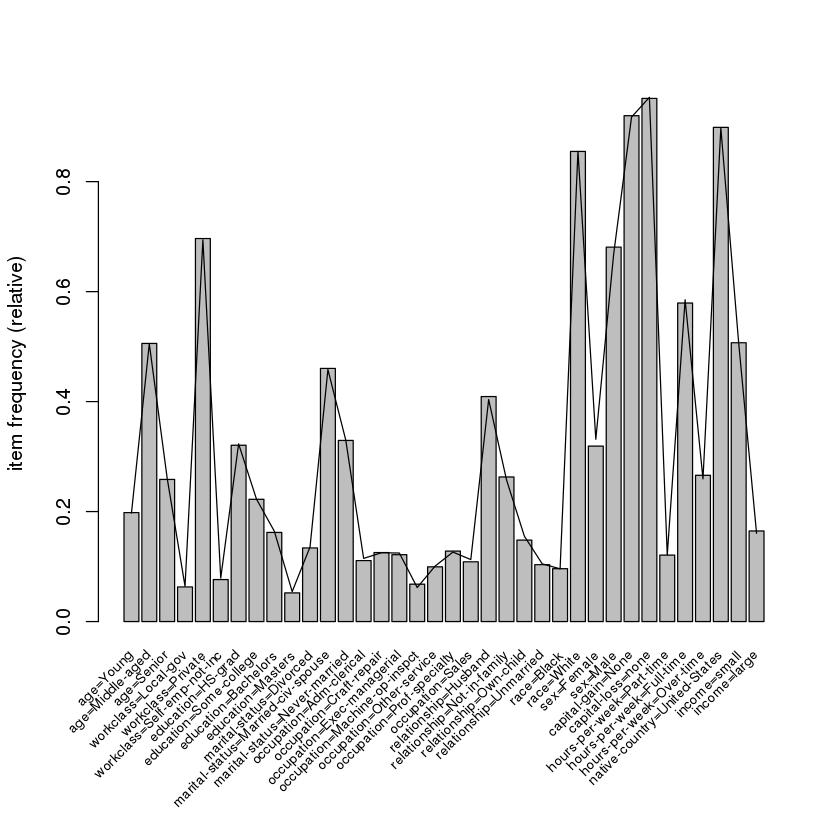

In [25]:
itemFrequencyPlot(AdultSample, population = Adult, support = supp, cex.names = 0.7)

To compare the speed-up reached by sampling we use the Eclat algorithm to mine frequent itemsets on both, the database and the sample and compare the system time (in seconds) used for mining.

[**Eclat Reference: **](https://artax.karlin.mff.cuni.cz/r-help/library/arules/html/eclat.html)

**Arguments**
- data:  object of class transactions or any data structure which can be coerced into transactions (e.g., binary matrix, data.frame).
- parameter: object of class ECparameter or named list (default values are: support 0.1 and maxlen 5)
- control object of class ECcontrol or named list for algorithmic controls.

In [26]:
time <- system.time(itemsets <- eclat(data = Adult, parameter = list(support = supp), control = list(verbose = FALSE)))
time

   user  system elapsed 
  0.191   0.001   0.192 

The paremeter verbose = FALSE will suppress all the summary deatils of running the algorithm

In [27]:
timeSample <- system.time(itemsetsSample <- eclat(AdultSample, parameter = list(support = supp), control = list(verbose = FALSE)))
timeSample

   user  system elapsed 
  0.040   0.000   0.039 

The first element of the vector returned by system.time() gives the (user) CPU time needed for the execution of the statement in its argument. Therefore, mining the sample instead of the whole data base results in a speed-up factor as calculated below

In [28]:
# speed up
time[1] / timeSample[1]

user.self 
    4.775

To evaluate the accuracy for the itemsets mined from the sample, analyze the difference between the two sets

In [29]:
itemsets

set of 8496 itemsets 

In [30]:
itemsetsSample

set of 8484 itemsets 

The two sets have roughly the same size. To check if the sets contain similar itemsets, match the sets and see what fraction of frequent itemsets found in the database were also found in the sample

**Reference: ** [match()](http://rfunction.com/archives/910)

The match() function will look for elements of itemsets match those of itemsetsSample. Notice that only the first occurrence of each element of itemsets is reported.

In [31]:
match <- match(itemsets, itemsetsSample, nomatch = 0)
match[1:10]

# itemsets where there is no match 0 is assigned as mentioned in the parameter nomatch=0

[1] 12 13 14 20 22 23 24 25 27  1

In [32]:
# remove no matches
sum(match > 0) / length(itemsets)

[1] 0.9690443

Almost all frequent itemsets were found using the sample. The summaries of the support of the frequent itemsets which were not found in the sample and the itemsets which were frequent in the sample although they were infrequent in the database, respectively, give

In [33]:
summary(quality(itemsets[match == 0])$support)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05002 0.05046 0.05102 0.05116 0.05158 0.05573 

In [34]:
summary(quality(itemsetsSample[-match])$support)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05005 0.05049 0.05114 0.05151 0.05212 0.05765 

This shows that only itemsets with support very close to the minimum support were falsely missed or found. For the frequent itemsets which were found in the database and in the sample, calculate accuracy from the the error rate.

In [35]:
supportItemsets <- quality(itemsets[which(match > 0)])$support
supportSample <- quality(itemsetsSample[match])$support
accuracy <- 1 - abs(supportSample - supportItemsets) / supportItemsets
summary(accuracy)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8708  0.9616  0.9789  0.9739  0.9899  1.0000 

The summary shows that sampling resulted in finding the support of itemsets with high accuracy. This small example illustrates that for extremely large databases or for application where mining time is important, sampling can be a powerful technique